# Brand Affinity Analysis

![](luxury-brand-design-agency-3.jpg)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

sns.set()

## Exploratory Data Analysis

In [2]:
# brand affinity matrix
df_ba = pd.read_excel('data/affinity_dataset_SS21.xlsx')

# keep the relevant dimensions
df_ba = df_ba[['DISTINCT','Corrected Gender','POV','Reach','Brand % of Total Buy']]

# rename columns for ease of use
df_ba.rename(columns={'DISTINCT':'brand','Corrected Gender':'gender','POV':'pov','Reach':'reach','Brand % of Total Buy':'investment'}, inplace=True)

# scale investment values, originally reported as percentage
df_ba.investment = df_ba.investment

# drop brands with no classification data
df_ba = df_ba.dropna().reset_index(drop=True)
df_ba.head()

,brand,gender,pov,reach,investment
0,032c,B,elite,niche,0.00043
1,11 by Boris Bidjan Saberi,M,neutral,niche,0.00067
2,132 5. ISSEY MIYAKE,M,good,medium,0.00015
3,3.1 Phillip Lim,W,good,medium,0.00069
4,3MAN,M,neutral,niche,0.00013


In [3]:
df_ba[df_ba.brand=='SKIMS']

,brand,gender,pov,reach,investment
580,SKIMS,W,good,top-of-mind,0.0127


In [4]:
df_ba[df_ba.brand=='Essentials-W']

,brand,gender,pov,reach,investment
131,Essentials-W,W,good,medium,0.1195


### About the data set : brand affinity matrix is defined by 3 categorical dimensions, and 1 numerical dimension

    the brand affinitiy matrix ranks brands based on their alignment with the SSENSE point of view.
    the SSENSE point of view is a collection of considerations set forth by planning, merchandising, marketing and sales that outline
    SSENSE branding and brand positioning.
    
    gender : [M,W,B]
    POV : ['Commercially Driven','Neutral','Good','Elite','Hero']
    reach : ['Top of Mind','Medium','Niche']
    investment : float

In [5]:
df_ba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   brand       604 non-null    object 
 1   gender      604 non-null    object 
 2   pov         604 non-null    object 
 3   reach       604 non-null    object 
 4   investment  604 non-null    float64
dtypes: float64(1), object(4)
memory usage: 23.7+ KB


In [6]:
# list of pov classes
list(df_ba.pov.unique())

['elite ',
 'neutral ',
 'good',
 'elite',
 'hero',
 'commercially driven',
 'Good',
 'commercially driven ']

In [7]:
# eliminate duplicates
df_ba.pov = df_ba.pov.str.lower()
df_ba.pov = df_ba.pov.str.strip()
list(df_ba.pov.unique())

['elite', 'neutral', 'good', 'hero', 'commercially driven']

In [8]:
# list of reach classes
list(df_ba.reach.unique())

['niche ',
 'medium ',
 ' top-of-mind',
 'top-of-mind',
 'medium',
 'Niche',
 'niche',
 'neutral']

In [9]:
# eliminate duplicates
df_ba.reach = df_ba.reach.str.lower()
df_ba.reach = df_ba.reach.str.strip()
list(df_ba.reach.unique())

['niche', 'medium', 'top-of-mind', 'neutral']

In [10]:
# neutral is not a valid classification for reach, this is an error
# drop brand
df_ba.drop(df_ba.index[df_ba.reach=='neutral'], inplace=True)
df_ba[df_ba.reach=='neutral']

,brand,gender,pov,reach,investment


In [71]:
print(df_ba.shape)
df_ba.head()

(603, 6)


,brand,gender,pov,reach,investment,cluster
0,032c,B,elite,niche,0.00043,5
1,11 by Boris Bidjan Saberi,M,neutral,niche,0.00067,0
2,132 5. ISSEY MIYAKE,M,good,medium,0.00015,6
3,3.1 Phillip Lim,W,good,medium,0.00069,6
4,3MAN,M,neutral,niche,0.00013,0


In [12]:
# unique pov classes: 'commercially driven','neutral', 'good','elite','hero'
# uniqu reach classes: 'top-of-mind','medium','niche'

df_mapped = df_ba.copy()

# transform numerical data to categorical
df_mapped['investment_bin'] = pd.cut(df_mapped['investment'], [0.000, 0.001, 0.005, 0.010, 0.030,0.15],
                              labels=['very small', 'small', 'mid', 'large','very large'])

In [13]:
df_mapped[df_mapped['investment_bin']=='very large']

,brand,gender,pov,reach,investment,investment_bin
63,Burberry,B,elite,top-of-mind,0.03767,very large
96,Converse,B,good,medium,0.03216,very large
131,Essentials-W,W,good,medium,0.11950,very large
132,Essentials-M,M,good,top-of-mind,0.11950,very large


In [14]:
df_mapped[df_mapped['investment_bin'].isnull()]

,brand,gender,pov,reach,investment,investment_bin
538,Mugler-M,M,neutral,medium,0.0,NaN


In [15]:
df_mapped = df_mapped.dropna().reset_index()
df_mapped.groupby('investment_bin').count().reset_index()

,investment_bin,index,brand,gender,pov,reach,investment
0,very small,456,456,456,456,456,456
1,small,98,98,98,98,98,98
2,mid,21,21,21,21,21,21
3,large,23,23,23,23,23,23
4,very large,4,4,4,4,4,4


#### One Hot Encoding

In [16]:
df_categorical = df_mapped.copy()
df_categorical.head()

,index,brand,gender,pov,reach,investment,investment_bin
0,0,032c,B,elite,niche,0.00043,very small
1,1,11 by Boris Bidjan Saberi,M,neutral,niche,0.00067,very small
2,2,132 5. ISSEY MIYAKE,M,good,medium,0.00015,very small
3,3,3.1 Phillip Lim,W,good,medium,0.00069,very small
4,4,3MAN,M,neutral,niche,0.00013,very small


In [17]:
# binary encode categorical dimensions

df_categorical_oe = df_categorical[['brand','investment']].join(
            [(pd.get_dummies(df_categorical['pov'], drop_first=False)),
             (pd.get_dummies(df_categorical['reach'], drop_first=False)),
             (pd.get_dummies(df_categorical['investment_bin'], drop_first=False))])

df_categorical_oe = df_categorical_oe.drop(['brand','investment'], axis=1)
df_categorical_oe.head()

,commercially driven,elite,good,hero,neutral,medium,niche,top-of-mind,very small,small,mid,large,very large
0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,0,0,0,0,1,0,1,0,1,0,0,0,0
2,0,0,1,0,0,1,0,0,1,0,0,0,0
3,0,0,1,0,0,1,0,0,1,0,0,0,0
4,0,0,0,0,1,0,1,0,1,0,0,0,0


## A Perceptual Map

#### Multidimensional scaling method

In [18]:
# standardization of numerical values

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

temp = df_categorical['investment'].values 
temp = temp.reshape(-1,1)
temp = StandardScaler().fit_transform(temp)

In [20]:
# principal componenet analysis
# ref : https://towardsdatascience.com/one-hot-encoding-standardization-pca-data-preparation-steps-for-segmentation-in-python-24d07671cf0b

from sklearn.decomposition import PCA

# Loop Function to identify number of principal components that explain at least 85% of the variance

for comp in range(df_categorical_oe.shape[1]):
    pca = PCA(n_components = comp, random_state=42)
    pca.fit(df_categorical_oe)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.85:
        break
        
Final_PCA = PCA(n_components = final_comp, random_state=42)
Final_PCA.fit(df_categorical_oe)

cluster_df = Final_PCA.transform(df_categorical_oe)
num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(final_comp,comp_check.sum()))

Using 5 components, we can explain 0.8765274901324431% of the variability in the original data.


In [21]:
cluster_df.shape

(602, 5)

In [22]:
from sklearn.metrics.pairwise import manhattan_distances as manhattan_distances

In [23]:
dist_matrix = manhattan_distances(cluster_df)
print(dist_matrix.shape)

(602, 602)


In [24]:
from sklearn import manifold
mds_method = manifold.MDS(n_components = 2, random_state=9999, dissimilarity='precomputed')
mds_fit = mds_method.fit(dist_matrix)
mds_coordinates = mds_method.fit_transform(dist_matrix)

In [25]:
plot_names = list(df_categorical.brand)

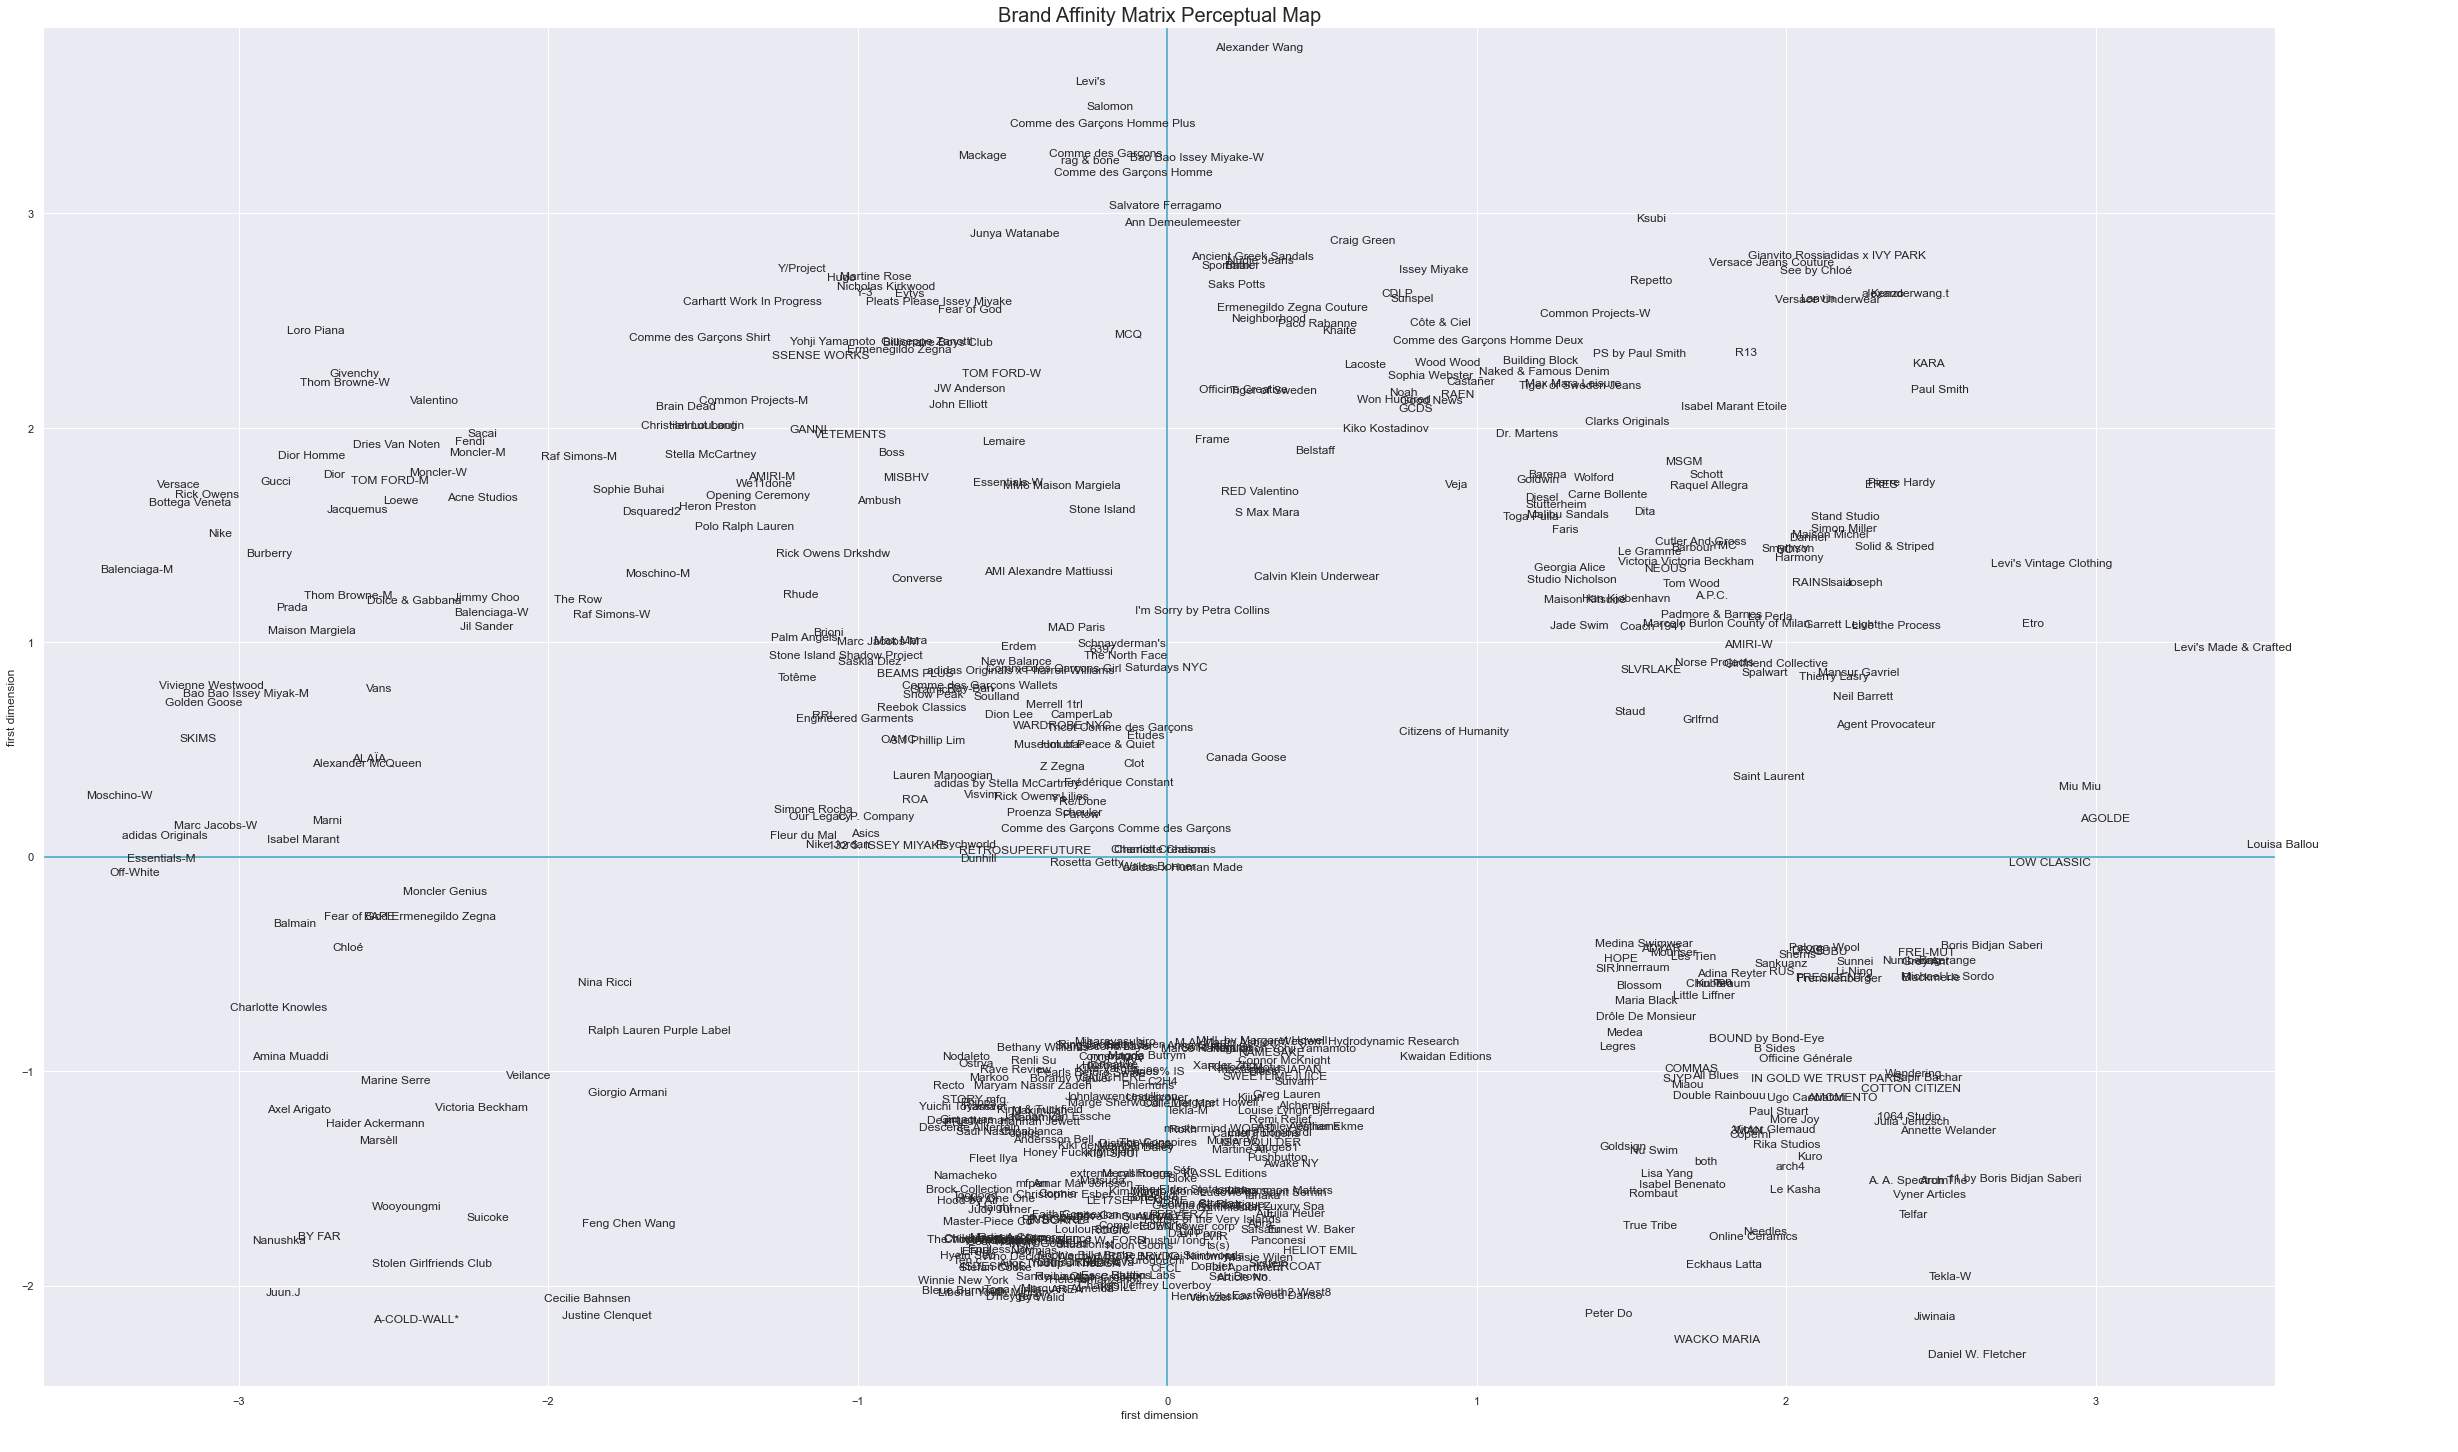

In [26]:
import random
plt.figure(figsize = (40,25))

plt.scatter(mds_coordinates[:,0],mds_coordinates[:,1], facecolors = 'none', edgecolors = 'none')
labels = plot_names
# add +/- value to y axis to eliminate overlap
for label, x, y in zip(labels, mds_coordinates[:,0], mds_coordinates[:,1]):
    x = x + random.uniform(-0.6,0.6)
    y = y + random.uniform(-0.6,0.6)
    plt.annotate(label, (x,y), xycoords = 'data')
plt.xlabel('first dimension')
plt.ylabel('first dimension')
plt.axhline(linewidth=2, color='c')
plt.axvline(linewidth=2, color='c')
plt.title('Perceptual Map if Brand Affinity', fontsize=20)
plt.show()

## Clustering

### K-means clustering

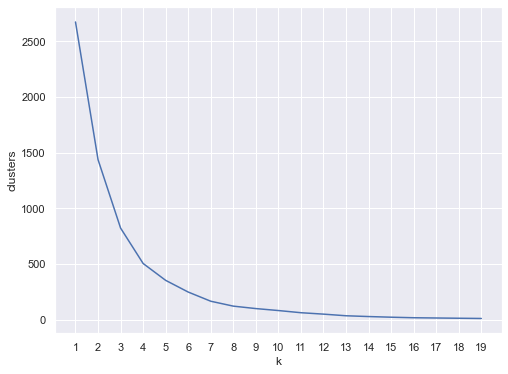

In [27]:
# determine optimal clusters using kmeans elbow method
from sklearn.cluster import KMeans

ssd = []
range_n_clusters = range(1,20)

for num_clusters in range_n_clusters:
    kmeans = KMeans(num_clusters)
    kmeans.fit(mds_coordinates)
    ssd_iter = kmeans.inertia_
    ssd.append(ssd_iter)

# plot the SSDs for each n_clusters
plt.figure(figsize=(8,6))
plt.plot(range_n_clusters, ssd)
plt.xticks(np.arange(1, 20, 1))
plt.xlabel('k')
plt.ylabel('clusters')
plt.show()

In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

kmeans = KMeans(14)
X_std = StandardScaler().fit_transform(mds_coordinates)
df_stdt = pd.DataFrame(X_std)
kmeans.fit(df_stdt)

x_clusters = kmeans.predict(df_stdt)
data_clusters = df_categorical.copy()
data_clusters['cluster'] = x_clusters

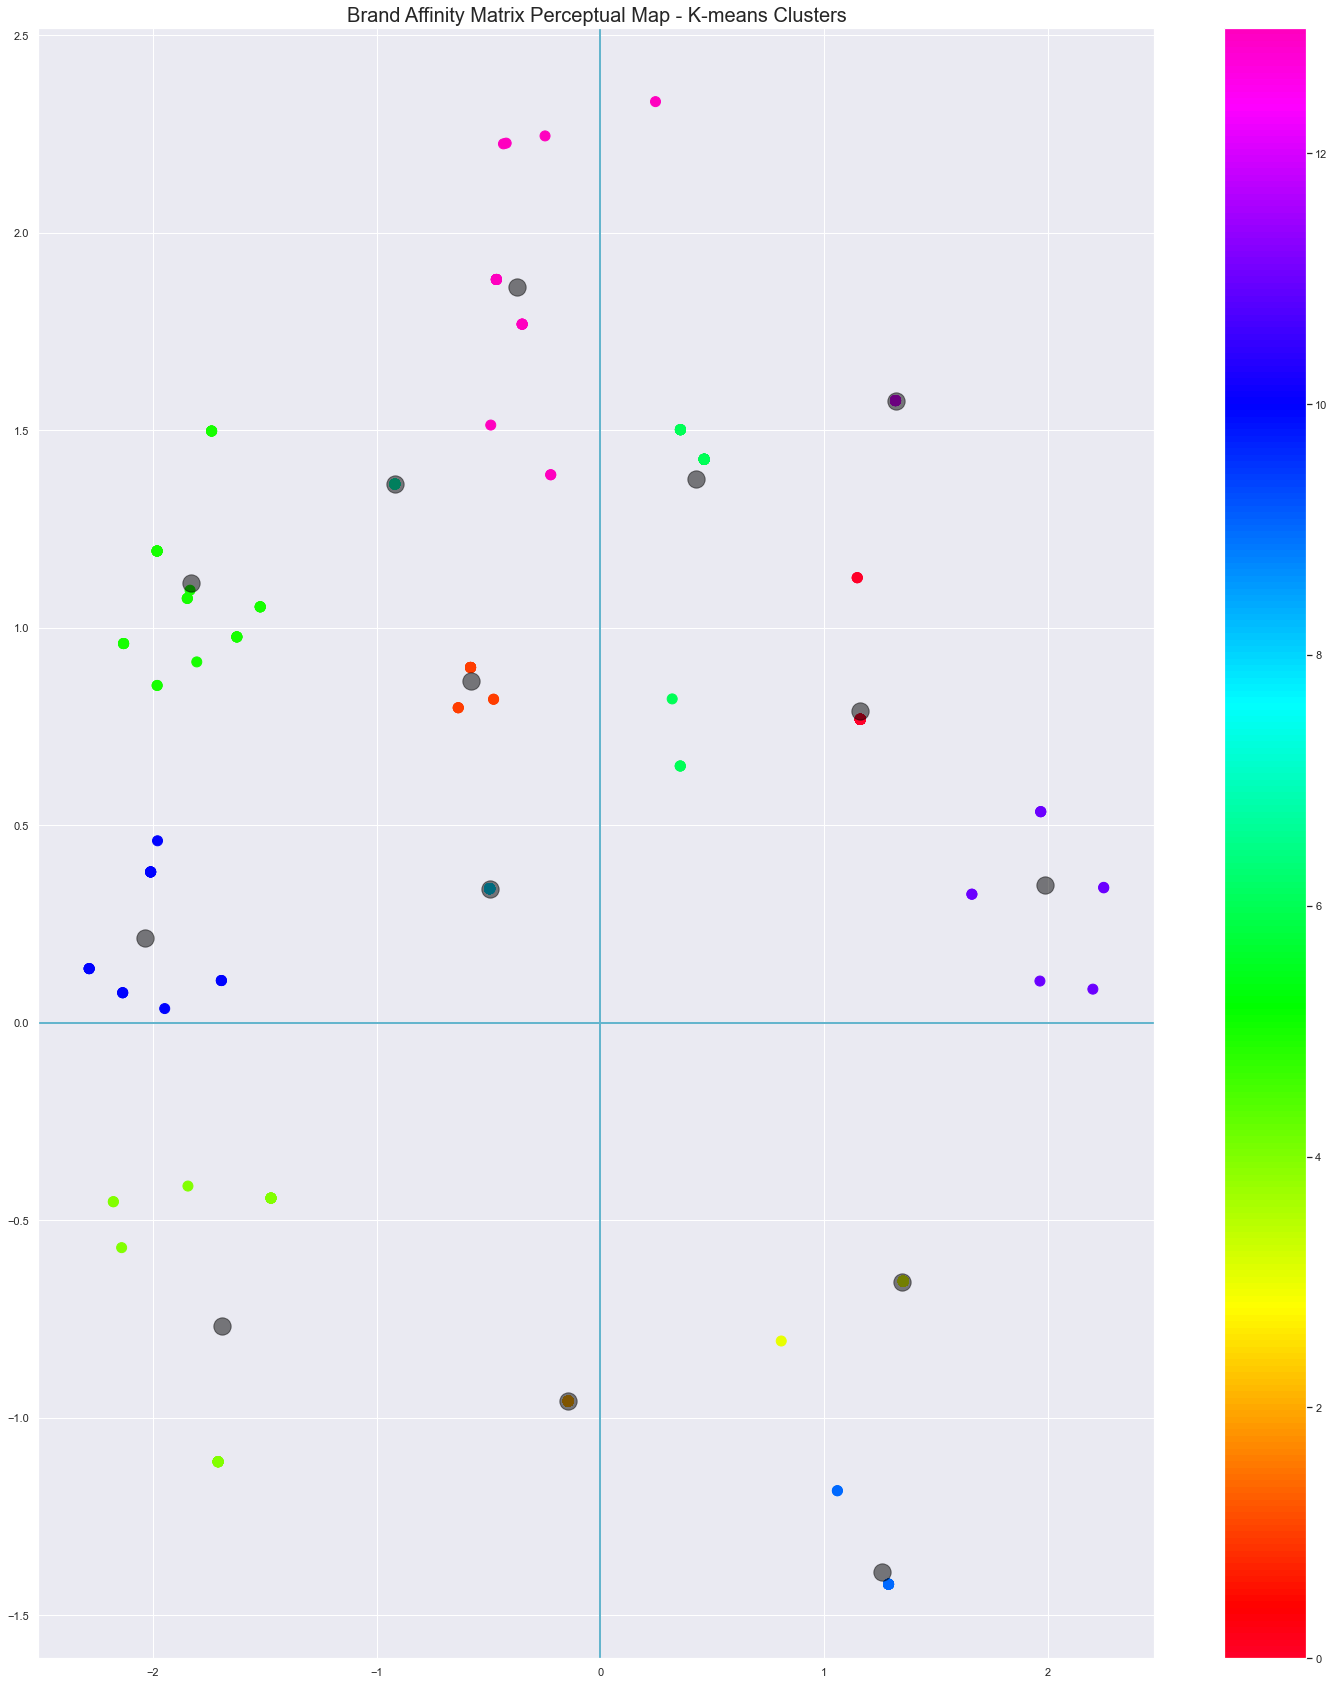

In [73]:
plt.figure(figsize=(25,30))

plt.scatter(df_stdt.iloc[:,0], df_stdt.iloc[:,1], c=x_clusters, s=100, cmap='gist_rainbow')
plt.colorbar()

labels = plot_names
for label, x, y in zip(labels, df_stdt.iloc[:,0], df_stdt.iloc[:,1]):
    x = x + random.uniform(-0.3, 0.3)
    y = y + random.uniform(-0.6, 0.6)
    plt.annotate(label, (x,y), xycoords = 'data')
            
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.5)
plt.title('Brand Affinity Matrix Perceptual Map - K-means Clusters', fontsize=20)
plt.axhline(linewidth=2, color='c')
plt.axvline(linewidth=2, color='c')
plt.show()

In [30]:
data_clusters.head()

,index,brand,gender,pov,reach,investment,investment_bin,cluster
0,0,032c,B,elite,niche,0.00043,very small,9
1,1,11 by Boris Bidjan Saberi,M,neutral,niche,0.00067,very small,3
2,2,132 5. ISSEY MIYAKE,M,good,medium,0.00015,very small,8
3,3,3.1 Phillip Lim,W,good,medium,0.00069,very small,8
4,4,3MAN,M,neutral,niche,0.00013,very small,3


### Brand Study, Burberry

In [31]:
data_clusters[data_clusters['brand']=='Burberry']

,index,brand,gender,pov,reach,investment,investment_bin,cluster
63,63,Burberry,B,elite,top-of-mind,0.03767,very large,5


In [32]:
brand_affinity = []
for c in set(list(data_clusters.cluster)):
    temp = data_clusters[data_clusters['cluster']==c]
    brand_affinity.append([c,list(temp.brand),len(list(temp.brand))])
    brand_affinity

brand_affinity
df = pd.DataFrame(brand_affinity, columns = ['cluster', 'brands','count of brands']) 
df

,cluster,brands,count of brands
0,0,"[A.P.C., AMIRI-W, Barbour, Barena, Carne Bolle...",53
1,1,"[Ambush, AMI Alexandre Mattiussi, AMIRI-M, Con...",14
2,2,"[4SDESIGNS, 99% IS, Ahluwalia, AïE, Aitor Thro...",201
3,3,"[11 by Boris Bidjan Saberi, 3MAN, A. A. Spectr...",70
4,4,"[A-COLD-WALL*, Axel Arigato, BAPE, Feng Chen W...",23
5,5,"[Acne Studios, Balenciaga-W, Balenciaga-M, Bot...",35
6,6,"[Bather, Belstaff, Calvin Klein Underwear, Can...",44
7,7,"[Billionaire Boys Club, Boss, Brain Dead, Carh...",21
8,8,"[132 5. ISSEY MIYAKE, 3.1 Phillip Lim, adidas ...",60
9,9,"[032c, ACRONYM, Daniel W. Fletcher, Eckhaus La...",15


In [33]:
burberry_affinity = data_clusters[data_clusters.cluster==data_clusters[data_clusters['brand']=='Burberry'].cluster.item()]
burberry_affinity.sort_values(by='investment')

,index,brand,gender,pov,reach,investment,investment_bin,cluster
459,459,Dior,W,hero,top-of-mind,0.00110,small,5
109,109,Dior Homme,M,hero,top-of-mind,0.00113,small,5
368,368,The Row,B,hero,top-of-mind,0.00146,small,5
293,293,Prada,B,hero,top-of-mind,0.00157,small,5
486,486,Jimmy Choo,W,commercially driven,top-of-mind,0.00170,small,5
82,82,Christian Louboutin,B,commercially driven,top-of-mind,0.00212,small,5
216,216,Loro Piana,B,elite,top-of-mind,0.00220,small,5
119,119,Dsquared2,M,commercially driven,top-of-mind,0.00232,small,5
299,299,Raf Simons-W,W,hero,top-of-mind,0.00240,small,5
300,300,Raf Simons-M,M,elite,top-of-mind,0.00240,small,5


### K-modes clustering

In [34]:
from kmodes.kprototypes import KPrototypes

In [35]:
data = df_ba.copy()
data = data[['gender','pov','reach','investment']]
data.investment = data.investment*100
data

,gender,pov,reach,investment
0,B,elite,niche,0.043
1,M,neutral,niche,0.067
2,M,good,medium,0.015
3,W,good,medium,0.069
4,M,neutral,niche,0.013
...,...,...,...,...
599,W,neutral,niche,0.020
600,W,neutral,medium,0.020
601,W,commercially driven,medium,0.020
602,W,good,medium,0.050


In [36]:
data_array = data.values

In [37]:
data_array[:,3] = data_array[:,3].astype(float)
data_array

array([['B', 'elite', 'niche', 0.043],
       ['M', 'neutral', 'niche', 0.067],
       ['M', 'good', 'medium', 0.015],
       ...,
       ['W', 'commercially driven', 'medium', 0.02],
       ['W', 'good', 'medium', 0.05],
       ['W', 'neutral', 'medium', 0.01]], dtype=object)

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


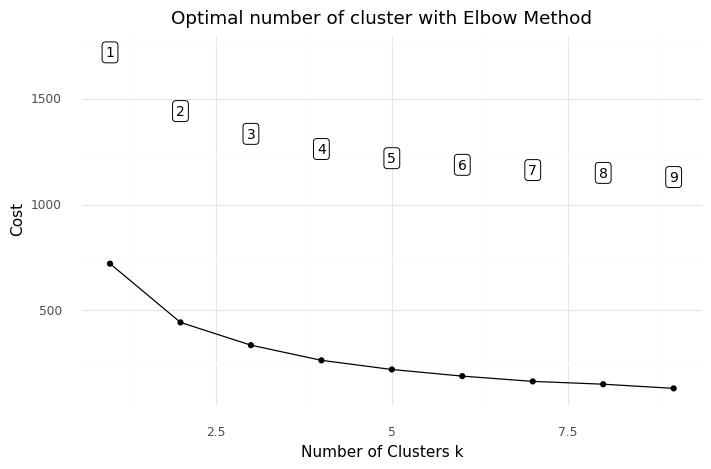

<ggplot: (113064961500)>

In [38]:
# ref : https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb

from plotnine import *
import plotnine

# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(data_array, categorical = [0,1,2])
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
        
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 10), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [39]:
kprototype = KPrototypes(n_clusters=7, verbose=0, max_iter=20)
clusters = kprototype.fit_predict(data_array, categorical=[0,1,2])
print(kprototype.cluster_centroids_)

[['0.02268711656441715' 'M' 'good' 'niche']
 ['0.08780882352941165' 'W' 'neutral' 'medium']
 ['0.28731707317073174' 'B' 'good' 'medium']
 ['1.6106666666666674' 'B' 'elite' 'top-of-mind']
 ['11.950000000000003' 'M' 'good' 'medium']
 ['0.038680981595091875' 'W' 'good' 'niche']
 ['0.06821428571428569' 'M' 'good' 'medium']]


In [40]:
cluster_dict = []
for c in clusters:
    cluster_dict.append(c)

In [41]:
df_ba['cluster'] = cluster_dict
df_ba.head()

,brand,gender,pov,reach,investment,cluster
0,032c,B,elite,niche,0.00043,5
1,11 by Boris Bidjan Saberi,M,neutral,niche,0.00067,0
2,132 5. ISSEY MIYAKE,M,good,medium,0.00015,6
3,3.1 Phillip Lim,W,good,medium,0.00069,6
4,3MAN,M,neutral,niche,0.00013,0


In [42]:
summary = df_ba.groupby('cluster').count()['brand']
summary = summary.reset_index()
summary

,cluster,brand
0,0,163
1,1,68
2,2,82
3,3,27
4,4,2
5,5,163
6,6,98


In [43]:
df_ba[df_ba['cluster']==0].head()

,brand,gender,pov,reach,investment,cluster
1,11 by Boris Bidjan Saberi,M,neutral,niche,0.00067,0
4,3MAN,M,neutral,niche,0.00013,0
5,4SDESIGNS,M,good,niche,0.00019,0
6,99% IS,M,good,niche,0.00039,0
8,A. A. Spectrum,M,neutral,niche,0.00009,0


In [44]:
df_ba[df_ba['cluster']==1].head()

,brand,gender,pov,reach,investment,cluster
15,adidas x IVY PARK,B,neutral,medium,0.00118,1
26,AMIRI-W,W,neutral,medium,0.00050,1
37,Balenciaga-W,W,elite,top-of-mind,0.00675,1
40,Bao Bao Issey Miyake-W,W,neutral,top-of-mind,0.00240,1
83,Clarks Originals,B,neutral,medium,0.00109,1


In [45]:
df_ba[df_ba['cluster']==2].head()

,brand,gender,pov,reach,investment,cluster
7,A-COLD-WALL*,B,good,niche,0.00240,2
9,A.P.C.,B,neutral,medium,0.00612,2
12,adidas Originals,B,good,top-of-mind,0.00338,2
24,Ambush,B,good,medium,0.00809,2
25,AMI Alexandre Mattiussi,B,good,medium,0.00618,2


In [46]:
df_ba[df_ba['cluster']==3].head()

,brand,gender,pov,reach,investment,cluster
10,Acne Studios,B,elite,top-of-mind,0.01209,3
22,Alexander McQueen,B,good,top-of-mind,0.01735,3
27,AMIRI-M,M,good,medium,0.01253,3
63,Burberry,B,elite,top-of-mind,0.03767,3
90,Comme des Garçons Play,B,good,top-of-mind,0.01336,3


In [47]:
df_ba[df_ba['cluster']==4].head()

,brand,gender,pov,reach,investment,cluster
131,Essentials-W,W,good,medium,0.1195,4
132,Essentials-M,M,good,top-of-mind,0.1195,4


In [48]:
df_ba[df_ba['cluster']==5].head()

,brand,gender,pov,reach,investment,cluster
0,032c,B,elite,niche,0.00043,5
19,Aitor Throup’s TheDSA,B,good,niche,0.00037,5
20,Alan Crocetti,B,good,niche,0.00046,5
28,Andersson Bell,B,good,niche,0.00099,5
34,AURALEE,B,good,niche,0.00037,5


In [49]:
df_ba[df_ba['cluster']==6].head()

,brand,gender,pov,reach,investment,cluster
2,132 5. ISSEY MIYAKE,M,good,medium,0.00015,6
3,3.1 Phillip Lim,W,good,medium,0.00069,6
13,adidas Originals x Pharrell Williams,M,good,medium,0.00098,6
14,adidas x Human Made,M,good,medium,0.00057,6
38,Balenciaga-M,M,hero,top-of-mind,0.00675,6


In [50]:
burberry_affinity_mode = df_ba[df_ba.cluster==df_ba[df_ba['brand']=='Burberry'].cluster.item()]
burberry_affinity_mode.sort_values(by='investment')

,brand,gender,pov,reach,investment,cluster
187,Jil Sander,B,elite,top-of-mind,0.00698,3
247,Moncler-M,M,elite,top-of-mind,0.00740,3
246,Moncler-W,W,elite,top-of-mind,0.00830,3
138,Fear of God,B,elite,medium,0.01075,3
153,Givenchy,B,elite,top-of-mind,0.01131,3
423,Alexander Wang,W,neutral,top-of-mind,0.01160,3
10,Acne Studios,B,elite,top-of-mind,0.01209,3
215,Loewe,B,hero,top-of-mind,0.01240,3
27,AMIRI-M,M,good,medium,0.01253,3
580,SKIMS,W,good,top-of-mind,0.01270,3


## Comparing K-means to K-modes Results

In [51]:
compare = pd.merge(burberry_affinity, burberry_affinity_mode, on=['brand'], how='inner')
compare

,index,brand,gender_x,pov_x,reach_x,investment_x,investment_bin,cluster_x,gender_y,pov_y,reach_y,investment_y,cluster_y
0,10,Acne Studios,B,elite,top-of-mind,0.01209,large,5,B,elite,top-of-mind,0.01209,3
1,63,Burberry,B,elite,top-of-mind,0.03767,very large,5,B,elite,top-of-mind,0.03767,3
2,140,Fendi,B,elite,top-of-mind,0.01275,large,5,B,elite,top-of-mind,0.01275,3
3,153,Givenchy,B,elite,top-of-mind,0.01131,large,5,B,elite,top-of-mind,0.01131,3
4,161,Gucci,B,hero,top-of-mind,0.01974,large,5,B,hero,top-of-mind,0.01974,3
5,184,Jacquemus,B,elite,top-of-mind,0.01821,large,5,B,elite,top-of-mind,0.01821,3
6,187,Jil Sander,B,elite,top-of-mind,0.00698,mid,5,B,elite,top-of-mind,0.00698,3
7,215,Loewe,B,hero,top-of-mind,0.01240,large,5,B,hero,top-of-mind,0.01240,3
8,222,Maison Margiela,B,hero,top-of-mind,0.02030,large,5,B,hero,top-of-mind,0.02030,3
9,246,Moncler-W,W,elite,top-of-mind,0.00830,mid,5,W,elite,top-of-mind,0.00830,3


In [52]:
(len(burberry_affinity[(burberry_affinity.brand.isin(compare.brand))&(burberry_affinity_mode.brand.isin(compare.brand))])/len(burberry_affinity))*100

<ipython-input-52-6f008e55c01d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


48.57142857142857

In [53]:
(len(burberry_affinity[(burberry_affinity.brand.isin(compare.brand))&(burberry_affinity_mode.brand.isin(compare.brand))])/len(burberry_affinity_mode))*100

<ipython-input-53-df7342562c10>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


62.96296296296296

## Google Analytics Ecommerce analysis

### Data extraction

bigquery query statement (standardSQL)

    WITH tbl_trx AS 

    (SELECT date, item.transactionId AS transaction_id,
           item.productsku AS product_sku,
           item.productName AS product_name,
           IFNULL(SUM(item.itemquantity),0) AS quantity,
           IFNULL(ROUND(SUM(item.itemrevenue)/1000000,0),0) AS product_revenue
    FROM `utopian-catfish-599.843777.ga_sessions_*`, 
    UNNEST(hits) AS h
    WHERE _table_suffix BETWEEN '20210201' AND '20210430' 
          AND IFNULL(ROUND((item.itemrevenue)/1000000,0),0) > 0 
          AND LOWER(device.operatingSystem) not like '%linux%'
          AND not(trafficSource.source = 'polyvore.com' 
          AND trafficSource.medium = 'redirect') 
    --       AND item.transactionId ='1141283693974' 
    GROUP BY
        date,
        transaction_id,
        product_sku,
        product_name
    ORDER BY transaction_id DESC)
      SELECT * 
      FROM tbl_trx
      LEFT JOIN (SELECT product_id 
             , SAFE_CAST(SUBSTRING(sku,0,13) AS STRING) SKU
             , gender
             , department
             , category
             , brand
          FROM `utopian-catfish-599.om_dashboard.product_categories_historical`
          GROUP BY 1,2,3,4,5,6
        ) tbl_hist
        ON tbl_trx.product_sku = tbl_hist.SKU

### Ecommerce analysis

    Top 10 brand affinity is determined in 2 ways, by customer segment and by transaction
    idenfying customers who shopped a brand and then querying all other brands also purchased by customer segment ie. Brands shopped by Burberry customers
    these brands are then ranked by
    this provides insights on customers

    brands that are often shopped alongside a given brand can give us an indication of brand affinity
    here we explore ecommerce transactional data that lists all other brands that are shopped alongside Burberry products, as our case study.
    we compare the results of our previous classification, through k-means and k-modes clustering

In [54]:
# google analytics bigquery SQL output for transactions from 2021-02-01 to 2021-04-30
df_tr = pd.read_csv('data/trx_data_20210201-20210430.csv')
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463720 entries, 0 to 463719
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             463720 non-null  int64  
 1   transaction_id   463720 non-null  int64  
 2   product_sku      463720 non-null  object 
 3   product_name     463720 non-null  object 
 4   quantity         463720 non-null  int64  
 5   product_revenue  463720 non-null  int64  
 6   product_id       463673 non-null  float64
 7   SKU              463673 non-null  object 
 8   gender           463673 non-null  object 
 9   department       463673 non-null  object 
 10  category         463673 non-null  object 
 11  brand            463486 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 42.5+ MB


In [55]:
df_tr.head()

,date,transaction_id,product_sku,product_name,quantity,product_revenue,product_id,SKU,gender,department,category,brand
0,20210421,1133112544654,211444M489005,Completedworks-Wake Ceramic Vase,1,185,6440171.0,211444M489005,Everything Else,HOME,VESSELS,Completedworks
1,20210318,1117572885184,211653M217066,Versace Underwear-2-PACK BLACK/BLACK VERSACE B...,1,93,6200931.0,211653M217066,Men,CLOTHING,UNDERWEAR & LOUNGEWEAR,Versace Underwear
2,20210318,1117627899394,211686M429002,Vintner&#039;s Daughter-Active Treatment Essence,1,310,6662851.0,211686M429002,Everything Else,SELF-CARE,FACE,Vintner&#039;s Daughter
3,20210205,1097485358044,211733M000021,Christophe Robin-travel hairbrush,1,109,6746981.0,211733M000021,Everything Else,SELF-CARE,HAIR,Christophe Robin
4,20210422,1133398508044,211683M489000,Aesop-Aesop Post-Poo Drops 100mL,1,40,6661851.0,211683M489000,Everything Else,HOME,CANDLES & FRAGRANCES,Aesop


In [56]:
data = df_tr.copy()
data = data.dropna()
temp = data.groupby(['transaction_id', 'brand'])['date'].count()
temp = pd.DataFrame(temp)
temp = temp.reset_index()
temp

,transaction_id,brand,date
0,290475028858,Valentino,1
1,434843302954,Neil Barrett,1
2,434843302954,TAKAHIROMIYASHITA TheSoloist.,1
3,1093429382134,Nike,2
4,1093429461064,Moncler,1
...,...,...,...
399545,1137993260134,Nike,1
399546,1137993339064,Salvatore Ferragamo,1
399547,1137993654784,Justine Clenquet,1
399548,1137993812644,Maison Kitsuné,1


In [57]:
# top 10 shopped brands by units sold

temp = data.groupby(['brand'])['quantity'].count()
temp = pd.DataFrame(temp).sort_values(by='quantity',ascending=False)
temp = temp.reset_index()
temp.nlargest(10, 'quantity')

,brand,quantity
0,Essentials,52969
1,Nike,43106
2,Converse,39203
3,Comme des Garçons Play,15042
4,Gucci,13617
5,Off-White,13081
6,SKIMS,9437
7,Palm Angels,9114
8,Maison Margiela,8470
9,Alexander McQueen,7340


In [58]:
# top 10 brands shopped by revenue

top_10 = pd.DataFrame(data.groupby('brand').sum('product_revenue')['product_revenue'].sort_values(ascending=False).nlargest(10))
top_10 = top_10.reset_index()
top_10

,brand,product_revenue
0,Gucci,9857587
1,Essentials,5563307
2,Saint Laurent,5166380
3,AMIRI,4815857
4,Nike,4660454
5,Off-White,4649570
6,Converse,4279600
7,Alexander McQueen,4144392
8,Maison Margiela,3745061
9,Bottega Veneta,3093285


#### Brand Study, Gucci, Essentials, AMIRI & Burberry

In [59]:
# Gucci

gucci_tr = list(data[data['brand'].str.contains('Gucci')]['transaction_id'])
gucci_tr

gucci_aff = []
for tr in gucci_tr:
    brand = data[data['transaction_id']==tr].brand
    for br in brand:
        gucci_aff.append(br)

res = [[x,gucci_aff.count(x)] for x in set(gucci_aff)]
df = pd.DataFrame.from_records(res)
df.columns = ['brand','occurence']
df.sort_values(by='occurence',ascending=False).nlargest(11,'occurence')

,brand,occurence
121,Gucci,15799
354,Nike,273
44,Burberry,213
366,Off-White,190
349,Saint Laurent,190
24,Palm Angels,156
300,Fendi,150
198,Balenciaga,140
200,Versace,132
164,Alexander McQueen,120


In [60]:
# Essentials

brand_tr = list(data[data['brand'].str.contains('Essentials')]['transaction_id'])

brand_aff = []
for tr in brand_tr:
    brand = data[data['transaction_id']==tr].brand
    for br in brand:
        brand_aff.append(br)

res = [[x,brand_aff.count(x)] for x in set(brand_aff)]
df = pd.DataFrame.from_records(res)
df.columns = ['brand','occurence']
df.sort_values(by='occurence',ascending=False).nlargest(11,'occurence')

,brand,occurence
204,Essentials,88619
385,Nike,1148
350,AMI Alexandre Mattiussi,390
101,Converse,281
53,Comme des Garçons Play,273
162,SKIMS,269
405,Off-White,225
281,Acne Studios,207
21,Palm Angels,166
402,adidas Originals,165


In [61]:
# AMIRI

brand_tr = list(data[data['brand'].str.contains('AMIRI')]['transaction_id'])

brand_aff = []
for tr in brand_tr:
    brand = data[data['transaction_id']==tr].brand
    for br in brand:
        brand_aff.append(br)

res = [[x,brand_aff.count(x)] for x in set(brand_aff)]
df = pd.DataFrame.from_records(res)
df.columns = ['brand','occurence']
df.sort_values(by='occurence',ascending=False).nlargest(11,'occurence')

,brand,occurence
34,AMIRI,6916
58,Palm Angels,181
170,Off-White,133
105,Gucci,92
128,Rhude,72
32,Essentials,65
63,Heron Preston,61
149,Nike,54
75,Balenciaga,48
100,Burberry,42


In [62]:
# Burberry

brand_tr = list(data[data['brand'].str.contains('Burberry')]['transaction_id'])

brand_aff = []
for tr in brand_tr:
    brand = data[data['transaction_id']==tr].brand
    for br in brand:
        brand_aff.append(br)

res = [[x,brand_aff.count(x)] for x in set(brand_aff)]
df = pd.DataFrame.from_records(res)
df.columns = ['brand','occurence']
burberry_top10_trx = df.sort_values(by='occurence',ascending=False).nlargest(11,'occurence')
burberry_top10_trx

,brand,occurence
32,Burberry,7428
98,Gucci,213
315,Off-White,144
18,Palm Angels,131
303,Nike,111
145,Essentials,106
162,Versace,96
94,Paul Smith,86
128,Alexander McQueen,83
253,Fendi,78


In [64]:
compare_trx_means = pd.merge(burberry_top10_trx, burberry_affinity, on=['brand'], how='inner')
compare_trx_means

,brand,occurence,index,gender,pov,reach,investment,investment_bin,cluster
0,Burberry,7428,63,B,elite,top-of-mind,0.03767,very large,5
1,Gucci,213,161,B,hero,top-of-mind,0.01974,large,5
2,Nike,111,264,B,hero,top-of-mind,0.01822,large,5
3,Versace,96,390,B,elite,top-of-mind,0.01821,large,5
4,Fendi,78,140,B,elite,top-of-mind,0.01275,large,5


In [65]:
len(compare_trx_means)/len(burberry_top10_trx)*100

45.45454545454545

In [66]:
compare_trx_mode = pd.merge(burberry_top10_trx, burberry_affinity_mode, on=['brand'], how='inner')
compare_trx_mode

,brand,occurence,gender,pov,reach,investment,cluster
0,Burberry,7428,B,elite,top-of-mind,0.03767,3
1,Gucci,213,B,hero,top-of-mind,0.01974,3
2,Off-White,144,B,good,top-of-mind,0.01739,3
3,Palm Angels,131,B,good,medium,0.01554,3
4,Nike,111,B,hero,top-of-mind,0.01822,3
5,Versace,96,B,elite,top-of-mind,0.01821,3
6,Alexander McQueen,83,B,good,top-of-mind,0.01735,3
7,Fendi,78,B,elite,top-of-mind,0.01275,3


In [67]:
len(compare_trx_mode)/len(burberry_top10_trx)*100

72.72727272727273

In [68]:
df_other = burberry_top10_trx[burberry_top10_trx['brand'].isin(compare_trx_mode['brand']) == False]
list(df_other['brand'])

['Essentials', 'Paul Smith', 'Balenciaga']

In [69]:
df_ba[df_ba['brand'].isin(['Burberry','Essentials-W', 'Essentials-M', 'Paul Smith', 'Balenciaga-W', 'Balenciage-M'])]

,brand,gender,pov,reach,investment,cluster
37,Balenciaga-W,W,elite,top-of-mind,0.00675,1
63,Burberry,B,elite,top-of-mind,0.03767,3
131,Essentials-W,W,good,medium,0.11950,4
132,Essentials-M,M,good,top-of-mind,0.11950,4
285,Paul Smith,M,neutral,medium,0.00247,1
